# Catboost predictor - Frequency encoded
Implemented version of the catboost model predictor model with one-hot encoding

In [9]:
# import basic libraries
import pandas as pd

# import machine learning libraries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#import catboost
from catboost import CatBoostRegressor

In [10]:
#import the data
X_train = pd.read_csv("data/generated/frequency/X_train.csv")
y_train = pd.read_csv("data/generated/frequency/y_train.csv")
X_test = pd.read_csv("data/generated/frequency/X_test.csv")
y_test = pd.read_csv("data/generated/frequency/y_test.csv")
X_test.head(50)

Unnamed: 0       Action org:resource  \
0      1080782      Created      User_54   
1      1080783      Created      User_54   
2      1080784     Obtained      User_54   
3      1080785  statechange      User_54   
4      1080786  statechange      User_54   
5      1080787      Created      User_54   
6      1080788  statechange      User_54   
7      1080789  statechange      User_54   
8      1080790      Deleted      User_54   
9      1080791      Created      User_54   
10     1080792     Obtained      User_54   
11     1080793  statechange      User_54   
12     1080794     Released      User_54   
13     1080795      Deleted       User_1   
14     1080796      Created       User_1   
15     1080797  statechange       User_1   
16     1080798  statechange       User_1   
17     1080799      Deleted       User_1   
18     1080800      Created      User_28   
19     1080801      Created      User_28   
20     1080802     Obtained      User_28   
21     1080803  statechange      User_28   
22     1080804  statechange      User_28   
23     1080805      Created      User_28   
24     1080806  statechange      User_28   
25     1080807  statechange      User_28   
26     1080808      Deleted      User_28   
27     1080809      Created      User_28   
28     1080810     Obtained      User_28   
29     1080811  statechange      User_28   
30     1080812     Released      User_28   
31     1080813      Deleted       User_1   
32     1080814      Created       User_1   
33     1080815      Deleted     User_123   
34     1080816      Created     User_123   
35     1080817     Obtained     User_123   
36     1080818  statechange     User_123   
37     1080819  statechange     User_123   
38     1080820      Deleted     User_123   
39     1080821      Created     User_123   
40     1080822     Obtained     User_123   
41     1080823  statechange     User_123   
42     1080824     Released     User_123   
43     1080825      Deleted     User_121   
44     1080826      Created     User_121   
45     1080827     Obtained     User_121   
46     1080828  statechange     User_121   
47     1080829     Released     User_121   
48     1080830     Obtained      User_83   
49     1080831     Released      User_83   

                                         concept:name  EventOrigin  \
0                                A_Create Application  Application   
1          A_Create ApplicationW_Complete application     Workflow   
2   A_Create ApplicationW_Complete applicationW_Co...     Workflow   
3   A_Create ApplicationW_Complete applicationW_Co...  Application   
4   A_Create ApplicationW_Complete applicationW_Co...  Application   
5   A_Create ApplicationW_Complete applicationW_Co...        Offer   
6   A_Create ApplicationW_Complete applicationW_Co...        Offer   
7   A_Create ApplicationW_Complete applicationW_Co...        Offer   
8   A_Create ApplicationW_Complete applicationW_Co...     Workflow   
9   A_Create ApplicationW_Complete applicationW_Co...     Workflow   
10  A_Create ApplicationW_Complete applicationW_Co...     Workflow   
11  A_Create ApplicationW_Complete applicationW_Co...  Application   
12  A_Create ApplicationW_Complete applicationW_Co...     Workflow   
13  A_Create ApplicationW_Complete applicationW_Co...     Workflow   
14  A_Create ApplicationW_Complete applicationW_Co...     Workflow   
15  A_Create ApplicationW_Complete applicationW_Co...  Application   
16  A_Create ApplicationW_Complete applicationW_Co...        Offer   
17  A_Create ApplicationW_Complete applicationW_Co...     Workflow   
18                               A_Create Application  Application   
19         A_Create ApplicationW_Complete application     Workflow   
20  A_Create ApplicationW_Complete applicationW_Co...     Workflow   
21  A_Create ApplicationW_Complete applicationW_Co...  Application   
22  A_Create ApplicationW_Complete applicationW_Co...  Application   
23  A_Create ApplicationW_Complete applicationW_Co...        Offer   
24  A_Cre

### Pre-process the data

In [12]:
y_test = y_test['remaining_time']
y_train = y_train['remaining_time']

In [13]:
# Drop the offer columns
X_train = X_train.drop(['FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted','MonthlyCost','Selected','CreditScore','OfferedAmount','OfferID','Unnamed: 0','time:timestamp'], axis=1)
# Drop the offer columns
X_test = X_test.drop(['FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted','MonthlyCost','Selected','CreditScore','OfferedAmount','OfferID','Unnamed: 0','time:timestamp'], axis=1)

In [14]:
#Drop some other unnecessary columns
#X_train = X_train.drop(['Action', 'EventID','case:ApplicationType','EventOrigin','lifecycle:transition'],axis=1)

#Drop some other unnecessary columns
#X_test = X_test.drop(['Action', 'EventID','case:ApplicationType','EventOrigin','lifecycle:transition'],axis=1)

In [15]:
#dropping the ID column
#X_train = X_train.drop(['case:concept:name'],axis=1)
#X_test = X_test.drop(['case:concept:name'],axis=1)

In [16]:
# Separate categorical and numeric features

categorical_features = ['org:resource','concept:name','case:LoanGoal','case:concept:name','Action', 'EventID','case:ApplicationType','EventOrigin','lifecycle:transition']
numeric_features = X_train.columns.difference(categorical_features)

# Convert categorical features to string
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

In [17]:
X_test.dtypes

Action                   object
org:resource             object
concept:name             object
EventOrigin              object
EventID                  object
lifecycle:transition     object
case:LoanGoal            object
case:ApplicationType     object
case:concept:name        object
case:RequestedAmount    float64
event_index_in_trace      int64
year                      int64
month                     int64
day                       int64
hour                      int64
minute                    int64
second                    int64
microsecond               int64
dtype: object

### Building the model

In [18]:
# Create a CatBoost regressor
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.01, loss_function='RMSE')

In [19]:
# Train the model
model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

0:	learn: 13.4422899	test: 11.9293129	best: 11.9293129 (0)	total: 1.28s	remaining: 10m 37s
10:	learn: 12.7055358	test: 11.5892344	best: 11.5892344 (10)	total: 5.44s	remaining: 4m 2s
20:	learn: 12.0634996	test: 11.2879457	best: 11.2879457 (20)	total: 8.21s	remaining: 3m 7s
30:	learn: 11.4921115	test: 11.0133206	best: 11.0133206 (30)	total: 14.7s	remaining: 3m 42s
40:	learn: 10.9633044	test: 10.8057750	best: 10.8057750 (40)	total: 22.4s	remaining: 4m 11s
50:	learn: 10.4898112	test: 10.6544860	best: 10.6544860 (50)	total: 29.6s	remaining: 4m 20s
60:	learn: 10.0784772	test: 10.5144843	best: 10.5144843 (60)	total: 34.9s	remaining: 4m 11s
70:	learn: 9.7215891	test: 10.3991125	best: 10.3991125 (70)	total: 42.8s	remaining: 4m 18s
80:	learn: 9.3957588	test: 10.2548510	best: 10.2548510 (80)	total: 48s	remaining: 4m 8s
90:	learn: 9.1077357	test: 10.0802255	best: 10.0802255 (90)	total: 51.4s	remaining: 3m 50s
100:	learn: 8.8598645	test: 9.9405842	best: 9.9405842 (100)	total: 53.3s	remaining: 3m 30

In [20]:
# Make predictions on the test set
y_pred = model.predict(X_test)

### Evaluate the model

In [21]:
# MSE
mean_squared_error(y_test, y_pred)

91.87029750260531

In [22]:
# R2
r2_score(y_test, y_pred)

0.3553624512171861

### Feature importance

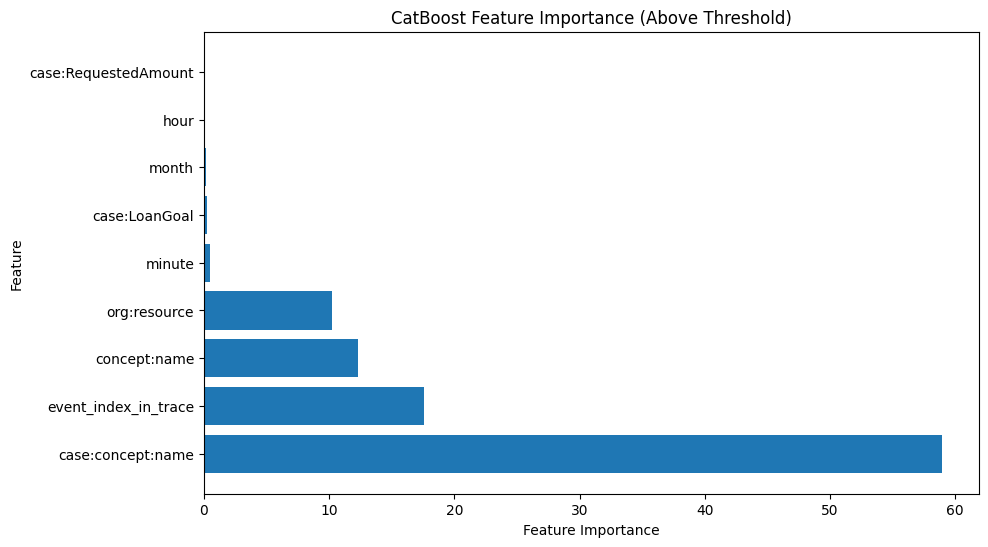

In [23]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained CatBoostRegressor
feature_importance = model.get_feature_importance()

# Get feature names from the original DataFrame (X_train)
feature_names = X_train.columns

# Create a DataFrame to store feature importance values with their corresponding names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Set the threshold for visibility
threshold = 0.01  # Adjust this threshold as needed

# Filter features based on the threshold
important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]

# Sort the DataFrame by importance in descending order
important_features = important_features.sort_values(by='Importance', ascending=False)

# Plot feature importance for only the relevant features
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance (Above Threshold)')
plt.show()
